# **Review**
![rev](https://datasciencedojo.com/wp-content/uploads/LLM-Website-blog-thumbnails-61-1.png)

# **🛠️ Tools**

- The tool abstraction in LangChain associates a Python function with a schema that defines the function's name, description and expected arguments.

- Tools can be passed to chat models that support tool calling allowing the model to request the execution of a specific function with specific inputs.

### **Their inputs are designed to be generated by models, and their outputs are designed to be passed back to models.**

- A toolkit is a collection of tools meant to be used together.
- https://python.langchain.com/docs/integrations/tools/


Besides the actual function that is called, the Tool consists of several components:

- **name**	`str`	Must be unique within a set of tools provided to an LLM or agent.
- **description**	`str`	Describes what the tool does. Used as context by the LLM or agent.
- **return_direct**	`boolean`	Only relevant for agents. When True, after invoking the given tool, the agent will stop and return the result direcly to the user.

## 🛠️ Tools vs 🧮 Functions in LangGraph / LangChain

| Aspect                        | 🔧 Tools (`@tool`)                              | 🧮 Functions (Python)                            |
|--------------------------------|------------------------------------------------|------------------------------------------------|
| Defined with                  | `@tool` decorator or `Tool` class              | Standard Python `def`                          |
| Purpose                       | Used by the **LLM itself** (tool-calling)      | Used by **you or LangGraph nodes**             |
| Triggered by                  | LLM via `tool_calls`                          | LangGraph edges or manual function call        |
| Input format                  | JSON arguments (auto-parsed by LLM)            | Python arguments                               |
| Return format                 | Must be `str` (LLM-readable)                  | Any Python object                              |
| Metadata                     | Requires name, description, args schema        | Optional (standard code)                      |
| Needs registration            | ✅ Yes (via `bind_tools(...)`)                 | ❌ No                                           |
| Used in LangGraph             | With `ToolNode` or agent-style pattern        | Anywhere as regular `add_node()`               |
| Execution trigger             | LLM decides when to call                      | You control when it's called                  |
| Example use                   | Calculator, search, database query             | Intermediate logic, routing, computation      |

---




## **How to create tools**

LangChain supports the creation of tools from:



- Functions;
- LangChain `Runnables`
- By sub-classing from `BaseTool`

In [3]:
# read api_key from file
with open(r'C:\Users\Seyed Barabadi\Downloads\Gen AI\Incedo Teaching/api_keys.txt', 'r') as file:
    api_key = file.read()


# Set loaded api_key as OPENAI_API_KEY environmental variable
import os
os.environ["OPENAI_API_KEY"] = api_key


## **🔧From Custom Functions**
The recommended way to create tools is using the `@tool decorator`

- Automatically infer the tool's name, description and expected arguments, while also supporting customization.
- Defining tools that return artifacts (e.g. images, dataframes, etc.)
- Hiding input arguments from the schema (and hence from the model) using injected tool arguments.

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 

In [5]:
from langchain_core.tools import tool


@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b."""
    return a * b

In [6]:
# Let's inspect some of the attributes associated with the tool.
print(multiply.name)
print(multiply.description)
print(multiply.args)

multiply
Multiply a and b.
{'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}



### Use the tool directly

In [7]:
multiply.invoke({'a': 3, 'b':4})

12

In [8]:
from typing import Annotated, List


# @tool supports parsing of annotations
@tool
def multiply_by_max(
    a: Annotated[int, "scale factor"],
    b: Annotated[List[int], "list of ints over which to take maximum"],
) -> int:
    """Multiply a by the maximum of b."""
    return a * max(b)



multiply_by_max.args_schema.model_json_schema()

{'description': 'Multiply a by the maximum of b.',
 'properties': {'a': {'description': 'scale factor',
   'title': 'A',
   'type': 'integer'},
  'b': {'description': 'list of ints over which to take maximum',
   'items': {'type': 'integer'},
   'title': 'B',
   'type': 'array'}},
 'required': ['a', 'b'],
 'title': 'multiply_by_max',
 'type': 'object'}

In [9]:
multiply_by_max.invoke({'a': 3, 'b':[1, 2 ,3, 4, 5]})

15

## **🏃‍♂️From Runnables**

In [10]:
from langchain_core.language_models import GenericFakeChatModel
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI



prompt = ChatPromptTemplate(
    [("human", "Hello. Please respond in the style of {answer_style}.")]
)


# Placeholder LLM
llm = ChatOpenAI(model="gpt-3.5-turbo")


chain = prompt | llm | StrOutputParser()


chain_as_tool = chain.as_tool(
                              name="Style responder",
                              description="tool description."
                             )


chain_as_tool

C:\Users\Seyed Barabadi\AppData\Local\Temp\ipykernel_17676\164054986.py:20: LangChainBetaWarning: This API is in beta and may change in the future.
  chain_as_tool = chain.as_tool(


StructuredTool(name='Style responder', description='tool description.', args_schema=<class 'langchain_core.utils.pydantic.PromptInput'>, func=<function convert_runnable_to_tool.<locals>.invoke_wrapper at 0x0000022610A309A0>, coroutine=<function convert_runnable_to_tool.<locals>.ainvoke_wrapper at 0x0000022610A30A40>)

In [11]:
chain.invoke({'answer_style': "Angry and rude"})

"I DON'T HAVE TIME FOR THIS STUPID CONVERSATION. WHAT DO YOU WANT?!"

## **🧼 Best practices**

- Tools that are well-named, correctly-documented and properly type-hinted are easier for models to use.
- Design simple and narrowly scoped tools, as they are easier for models to use correctly.
- Use chat models that support `tool-calling` APIs to take advantage of tools.

---

# **☎️ Calling Tools 🛠️**
There are cases where we want a **model to also interact directly with systems**, such as databases or an API. These systems often **have a particular input schema**; for example, APIs frequently have a required payload structure. This need motivates the concept of **tool calling**. You can use tool calling to request model responses that match a particular schema



**(1) Tool Creation:** Use the `@tool` decorator to create a tool. A tool is an association between a function and its schema. 

**(2) Tool Binding:** The tool needs to be connected to a model that supports tool calling. **This gives the model awareness of the tool** and the associated input schema required by the tool. 

**(3) Tool Calling:** When appropriate, the **model can decide to call a tool** and ensure its response conforms to the tool's input schema. 

**(4) Tool Execution:** The tool can be executed using the arguments provided by the model.

-https://python.langchain.com/docs/concepts/tool_calling/

![name](https://python.langchain.com/assets/images/tool_calling_concept-552a73031228ff9144c7d59f26dedbbf.png)


### **Rrecommended Workflow**

```python
# Tool creation
tools = [my_tool]

# Tool binding
model_with_tools = model.bind_tools(tools)

# Tool calling 
response = model_with_tools.invoke(user_input)


## **1.Tool creation**

In [12]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


## **2. Tool binding**
###  The `.bind_tools()` method can be used to specify which tools are available for a model to call.

In [13]:
from langchain_openai import ChatOpenAI

tool_calling_model = ChatOpenAI(model="gpt-3.5-turbo")

In [14]:
llm_with_tools = tool_calling_model.bind_tools([multiply])
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000022610A90B50>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000022610AA1510>, root_client=<openai.OpenAI object at 0x0000022610A4E0D0>, root_async_client=<openai.AsyncOpenAI object at 0x0000022610A81110>, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [15]:
result = llm_with_tools.invoke("Hello world!")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 65, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BMmUEOapoTSDSQ51qEjf8CYgpx790', 'finish_reason': 'stop', 'logprobs': None}, id='run-3a8a7b9d-d079-4606-8078-09af72a5f9f6-0', usage_metadata={'input_tokens': 65, 'output_tokens': 11, 'total_tokens': 76, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

If we pass an input relevant to the tool, the model should choose to call it:

## **📞 3.Tool calling** (How to use chat models to call tools)
- A key principle of tool calling is that the **model decides when to use a tool based on the input's relevance.**
- The **model doesn't always need to call a tool.**
- For example, given an **unrelated input, the model would not call the too**

https://python.langchain.com/docs/how_to/tool_calling/

![tool_calling](https://python.langchain.com/assets/images/tool_call_example-2348b869f9a5d0d2a45dfbe614c177a4.png)

In [16]:
result = llm_with_tools.invoke("What is 2 multiplied by 3?")
result

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FIZrJ5yGnn7pe9wskNxMMghd', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 71, 'total_tokens': 89, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BMmUE5ZGaJ26AStDom5ZGFYMWayxo', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2d9e8f85-6955-4c23-bd44-be09b3a195cf-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_FIZrJ5yGnn7pe9wskNxMMghd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 71, 'output_tokens': 18, 'total_tokens': 89, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audi

In [17]:
result.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_FIZrJ5yGnn7pe9wskNxMMghd',
  'type': 'tool_call'}]

In [18]:
# unrelated input, the model would not call the tool
result = llm_with_tools.invoke("Hello world!")
result

AIMessage(content='Hi there! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 65, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BMmUF7LMPvJeEIQ2Kxh8Iyl8zAyJs', 'finish_reason': 'stop', 'logprobs': None}, id='run-8b50d25c-341b-4cf0-81bb-3f8a3ae9f893-0', usage_metadata={'input_tokens': 65, 'output_tokens': 12, 'total_tokens': 77, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [19]:
# tool_calls is an empty list
result.tool_calls

[]

## **🚦Attention**
Remember, while the name `"tool calling"` implies that the model is directly performing some action, this is actually not the case! The **model only generates the arguments to a tool, and actually running the tool (or not) is up to the user.**

Tool calling is a general technique that **generates structured output from a model, and you can use it even when you don't intend to invoke any tools.**

---

## **Example 2**

In [20]:
from langchain.chat_models import init_chat_model

# tool_calling_model = ChatOpenAI(model="gpt-3.5-turbo")
llm = init_chat_model("gpt-3.5-turbo", model_provider="openai")

In [21]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """Adds a and b."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b."""
    return a * b



tools = [add, multiply]
llm_with_tools = llm.bind_tools(tools)

In [22]:
query = "What is 3 * 12?"

llm_with_tools.invoke(query)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MKt3TYZ1skF7POjl9WzVwAqr', 'function': {'arguments': '{"a":3,"b":12}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 78, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BMmUGsf7KDr5GY69xix96zsgKoJ8K', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8d095847-043a-45d2-abcc-4ba9cd1d1b3a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_MKt3TYZ1skF7POjl9WzVwAqr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 78, 'output_tokens': 18, 'total_tokens': 96, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'au

In [23]:
from langchain_core.messages import HumanMessage


query = "What is 3 * 12? Also, what is 11 + 49?"
messages = [HumanMessage(query)]


ai_msg = llm_with_tools.invoke(messages)

ai_msg
# messages.append(ai_msg)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1BonaEljplhtZp730dB2DXY6', 'function': {'arguments': '{"a": 3, "b": 12}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_81O4IpGeH6iKUfnViFw9sFf8', 'function': {'arguments': '{"a": 11, "b": 49}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 88, 'total_tokens': 138, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BMmUHKVtf0CstATpJgUmg16fZJvFF', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-89be2b2c-a00b-4169-a1ca-2a55d506888e-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_1BonaEljplhtZp730dB2DXY6', 'type': 'tool_call'}, {'name': 'add', 'args': {'a': 1

In [24]:
# print(len(ai_msg.tool_calls))
ai_msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 12},
  'id': 'call_1BonaEljplhtZp730dB2DXY6',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 11, 'b': 49},
  'id': 'call_81O4IpGeH6iKUfnViFw9sFf8',
  'type': 'tool_call'}]

## Why Doesn't the Tool Return `6` in the Graph?

In this LangGraph example, you bind a tool (a Python function) to the LLM:

```python
def multiply(a: int, b: int) -> int:
    return a * b

llm_with_tools = llm.bind_tools([multiply])
```
Then you invoke the LLM with a message:

```python
llm_with_tools.invoke([HumanMessage(content="Multiply 2 and 3")])`

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_P8gn6QejXtPGqLY4uXIG3W3J',
  'type': 'tool_call'}]
```
## ❗️ Problem: It Doesn’t Return 6
Even though you ask the LLM to multiply 2 and 3, it does not return 6.

🔍 What’s Actually Happening
The LLM suggests calling the multiply tool by returning a `ToolCall.`

### But the LLM does not execute your Python function.

### You need to manually detect and run the tool.

✅ Correct Way to Handle It
You must:

- Detect the tool call

- Call the tool manually (e.g., `multiply(a=2, b=3)`)

- Return the result back as a `ToolMessage`

## **🚀 4. Tool Execution** (How to pass tool outputs to chat models)
`LangGraph` offers pre-built components (e.g., `ToolNode`) that will often **invoke the tool in behalf of the user.**


 https://python.langchain.com/docs/how_to/tool_results_pass_to_model/


In [28]:
for tool_call in ai_msg.tool_calls:
    print("tool_call:", tool_call)

    selected_tool = {"add": add, "multiply": multiply}[tool_call["name"].lower()] # add or multiply tools
    print("selected_tool:", selected_tool)

    tool_msg = selected_tool.invoke(tool_call)
    print("tool_msg:", tool_msg)
    
    print()
    messages.append(tool_msg)

messages

tool_call: {'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_1BonaEljplhtZp730dB2DXY6', 'type': 'tool_call'}
selected_tool: name='multiply' description='Multiplies a and b.' args_schema=<class 'langchain_core.utils.pydantic.multiply'> func=<function multiply at 0x000002260F154D60>
tool_msg: content='36' name='multiply' tool_call_id='call_1BonaEljplhtZp730dB2DXY6'

tool_call: {'name': 'add', 'args': {'a': 11, 'b': 49}, 'id': 'call_81O4IpGeH6iKUfnViFw9sFf8', 'type': 'tool_call'}
selected_tool: name='add' description='Adds a and b.' args_schema=<class 'langchain_core.utils.pydantic.add'> func=<function add at 0x0000022610AE5120>
tool_msg: content='60' name='add' tool_call_id='call_81O4IpGeH6iKUfnViFw9sFf8'



[HumanMessage(content='What is 3 * 12? Also, what is 11 + 49?', additional_kwargs={}, response_metadata={}),
 ToolMessage(content='36', name='multiply', tool_call_id='call_1BonaEljplhtZp730dB2DXY6'),
 ToolMessage(content='60', name='add', tool_call_id='call_81O4IpGeH6iKUfnViFw9sFf8')]

`HumanMessage(user query) --[invokes llm_with_tools] --> AIMessage`s (might include `tool_calls`)
- In this example `ai_msg`s includes 2 `AIMessage` each has a `tool_calls` dictionary
 
`tool_calls --[invokes a tool]--> ToolMessage(return of fucntion execution)`

### Note that each `ToolMessage` **must include a `tool_call_id` that matches an id in the original tool calls** that the model generates. This helps the model match tool responses with tool calls.

# **How to call tools using `ToolNode`**
- https://langchain-ai.github.io/langgraph/how-tos/tool-calling/

In [29]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


tool_calling_model = ChatOpenAI(model="gpt-3.5-turbo")


llm_with_tools = tool_calling_model.bind_tools([multiply])
llm_with_tools


# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

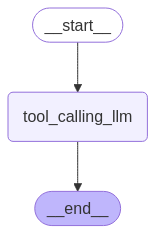

In [32]:
# Build graph
builder = StateGraph(MessagesState)


builder.add_node("tool_calling_llm", tool_calling_llm)


builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [33]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I help you today?


`%pip install grandalf`

### **The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.**

In [34]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})


for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_WKj7hJMsyp6Golhs9MdOERJk)
 Call ID: call_WKj7hJMsyp6Golhs9MdOERJk
  Args:
    a: 2
    b: 3
  multiply (call_MgHjR58UPAY0akaHa1D9rRLV)
 Call ID: call_MgHjR58UPAY0akaHa1D9rRLV
  Args:
    a: 3
    b: 2


In [35]:
from langchain_core.messages import ToolMessage


# Node ot manually run the tool
def tool_calling_llm(state: MessagesState):
    ai_msg = llm_with_tools.invoke(state["messages"]) # return a tool_call object
    print('ai_msg:', ai_msg)
    
    # Check if the latest message has a tool_calls
    if ai_msg.tool_calls:
        tool_call = ai_msg.tool_calls[0] 

        tool_name = tool_call["name"]
        args = tool_call["args"]
        tool_id = tool_call["id"]

        if tool_name == "multiply":
            result = multiply(**args)

            return {
                "messages": [
                    ai_msg,
                    ToolMessage(tool_call_id=tool_id, content=str(result))
                ]
            }

    return {"messages": [ai_msg]}

In [36]:
builder = StateGraph(MessagesState)


builder.add_node("tool_calling_llm", tool_calling_llm)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()



input = {"messages": [HumanMessage(content="Multiply 2 and 3")]}
result = graph.invoke(input)

for m in result["messages"]:
    m.pretty_print()

ai_msg: content='' additional_kwargs={'tool_calls': [{'id': 'call_9rglAd0n02LuUpYJ9e0HO9rE', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_ozefpN6JOkghJOxd5EBkwNbZ', 'function': {'arguments': '{"a": 3, "b": 2}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 61, 'total_tokens': 111, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BMmVfatAWTGiIciXFVMivNa7qiI08', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-64566e7a-aab0-48dd-ada1-f3ec17054779-0' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_9rglAd0n02LuUpYJ9e0HO9rE', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 3

In [37]:
input = {"messages": [HumanMessage(content="how are you?")]}
result = graph.invoke(input)

for m in result["messages"]:
    m.pretty_print()

ai_msg: content="I'm just a computer program, so I don't have feelings, but I'm here to help you with any questions or tasks you have. How can I assist you today?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 59, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BMmVgrrTVCmMfd8HXRO4V1VX92WVw', 'finish_reason': 'stop', 'logprobs': None} id='run-6b688d36-0e1f-4a67-92f8-f63354f3586e-0' usage_metadata={'input_tokens': 59, 'output_tokens': 38, 'total_tokens': 97, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
================================ Human Message =================================

how are you?
==========

---

# **How to call tools using `ToolNode`**
- https://langchain-ai.github.io/langgraph/how-tos/tool-calling/

In [38]:
from langgraph.prebuilt import ToolNode

####### TOOL #####################
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b



########## NODES #################
llm_with_tools = llm.bind_tools([multiply])


def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


tool_node = ToolNode([multiply])


######## GRAPH #################

builder = StateGraph(MessagesState)


builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tool_node", tool_node)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", "tool_node")
builder.add_edge( "tool_node", END)


graph = builder.compile()



input = {"messages": [HumanMessage(content="Multiply 2 and 3")]}
result = graph.invoke(input)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_QTPj2Ck39z4VWHYTRQmRK2Ha)
 Call ID: call_QTPj2Ck39z4VWHYTRQmRK2Ha
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
